In [1]:
# since there might be some random process going on so fix them
seed = 42

## Importing and re-formating data

First, we need to import the data we have obtained.  
1. match or battle log data: `{p1 pokemon, p2 pokemon, did p1 win?, URL}`  
2. base stats of each pokemon: `{'Id', 'Name', 'Type(s)', 'TotalBS', 'HP', 'Attack', 'Defense', 'Special Attack', 'Special Defense', 'Speed'}`  

<mark>TODO: should pl pokemon be the pokemon which moves first in the match? it is very ambiguous to have pl pokemon just picked by system randomly.</mark>  
randonly picked could be better, if p1 always move first then there will be an implicit variable

In [2]:
import json

# 1. match or battle log data
with open('./data/match_ok.json', 'r') as f:
    matches = json.load(f)
# 2. base stats of each pokemon
with open('./data/baseStats.json', 'r') as f:
    baseStats = json.load(f)

# to see how they look like
print(matches[3])
print(baseStats[3])

{'pokemon1': 'arcanine', 'pokemon2': 'sharpedo', 'pokemon1 wins': 1, 'url': 'https://replay.pokemonshowdown.com/destiny-challengecup1v1-550920.log'}
{'Id': 3, 'Name': 'Mega Venusaur', 'Type(s)': ['GRASS', 'POISON'], 'TotalBS': '625', 'HP': '80', 'Attack': '100', 'Defense': '123', 'Special Attack': '122', 'Special Defense': '120', 'Speed': '80'}



Then we need to construct the features and labels from these 2 databases,  
into a format looks like: `{'p1HP' ,'p1ATK' ,'p1DEF' ,'p1SpATK' ,'p1SpDEF' ,'p1SPD' ,'p2HP' ,'p2ATK' ,'p2DEF' ,'p2SpATK' ,'p2SpDEF' ,'p2SPD' ,'p1wins'}`

In [3]:
data = []
nameNotFound = []
N = len(matches)
for idx, match in enumerate(matches):  # from each match
    # extracting battle info of each match
    p1_pokemon = match['pokemon1']
    p2_pokemon = match['pokemon2']
    p1_wins = match['pokemon1 wins']
    # searching for the baseStats given the names of pokemons 
    info = [i for i in baseStats if p1_pokemon == i['Name'].lower() or p2_pokemon == i['Name'].lower()]  # this give [dict{p1 pokemon}, dict{p2 pokemon}]
    # creating new row format
    if len(info) == 2:  # for some reason some of the match contains pokemons that can't be found
        row = {
            'p1HP': int(info[0]['HP']),
            'p1ATK' : int(info[0]['Attack']),
            'p1DEF' : int(info[0]['Defense']),
            'p1SpATK' : int(info[0]['Special Attack']),
            'p1SpDEF' : int(info[0]['Special Defense']),
            'p1SPD' : int(info[0]['Speed']),
            'p2HP' : int(info[1]['HP']),
            'p2ATK' : int(info[1]['Attack']),
            'p2DEF' : int(info[1]['Defense']),
            'p2SpATK' : int(info[1]['Special Attack']),
            'p2SpDEF' : int(info[1]['Special Defense']),
            'p2SPD' : int(info[1]['Speed']),
            'p1wins': p1_wins
            }   
        data.append(row)  # store in a list
    else: 
        case = {'match index': idx, 'pokemon1': p1_pokemon, 'pokemon2': p2_pokemon, 'URL': match['url']}
        nameNotFound.append(case)
    print(f'{idx+1}/{N} done', end="\r")

print(f'\n{len(data)} rows of data can be proceeded, \n{len(nameNotFound)} rows of data went missing')

8895/8895 done
8475 rows of data can be proceeded, 
420 rows of data went missing


Seems like the problem of missing data is due to p1_pokemon is the same as p2_pokemon.  
<mark>TODO: are repeated pokemons bad data?</mark>  
include them

Convert them into pandas DataFrame for better visualistion and statistics summaries.  

In [4]:
import pandas as pd
import numpy as np

df = pd.DataFrame(data)
df.head()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins
0,50,75,75,65,65,50,100,150,120,120,100,90,1
1,85,73,70,73,115,67,80,80,90,110,130,110,1
2,66,41,77,61,87,23,100,120,100,150,120,90,0
3,90,110,80,100,80,95,70,120,40,95,40,95,1
4,115,140,130,55,55,40,85,50,95,120,115,80,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8475 entries, 0 to 8474
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   p1HP     8475 non-null   int64
 1   p1ATK    8475 non-null   int64
 2   p1DEF    8475 non-null   int64
 3   p1SpATK  8475 non-null   int64
 4   p1SpDEF  8475 non-null   int64
 5   p1SPD    8475 non-null   int64
 6   p2HP     8475 non-null   int64
 7   p2ATK    8475 non-null   int64
 8   p2DEF    8475 non-null   int64
 9   p2SpATK  8475 non-null   int64
 10  p2SpDEF  8475 non-null   int64
 11  p2SPD    8475 non-null   int64
 12  p1wins   8475 non-null   int64
dtypes: int64(13)
memory usage: 860.9 KB


In [6]:
df.describe()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins
count,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000,8475.000000
mean,82.725074,91.734041,84.913628,86.044956,85.775457,78.676224,83.767788,98.152330,89.796814,89.126136,87.443894,81.631150,0.515280
std,29.844925,29.647326,28.294264,29.296954,22.656316,26.470136,26.374245,30.915781,28.455747,29.616206,26.053244,28.020722,0.499796
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,0.000000
25%,65.000000,72.000000,70.000000,60.000000,75.000000,60.000000,70.000000,75.000000,70.000000,63.000000,71.000000,60.000000,0.000000
50%,80.000000,90.000000,83.000000,95.000000,85.000000,80.000000,80.000000,100.000000,90.000000,95.000000,90.000000,85.000000,1.000000
75%,95.000000,115.000000,100.000000,109.000000,100.000000,100.000000,97.000000,120.000000,100.000000,110.000000,100.000000,100.000000,1.000000
max,255.000000,181.000000,230.000000,173.000000,230.000000,200.000000,255.000000,181.000000,230.000000,173.000000,230.000000,200.000000,1.000000


done
___

## Statistics explanations 



In [71]:
df['p1ATKp2DEF'] = df['p1ATK'] - df['p2DEF']
df['p2ATKp1DEF'] = df['p2ATK'] - df['p1DEF']

df['p1SpATKp2SpDEF'] = df['p1SpATK'] - df['p2SpDEF']
df['p2SpATKp1SpDEF'] = df['p2SpATK'] - df['p1SpDEF']

df

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins,p1ATKp2DEF,p2ATKp1DEF,p1SpATKp2SpDEF,p2SpATKp1SpDEF
0,50,75,75,65,65,50,100,150,120,120,100,90,1,-45,75,-35,55
1,85,73,70,73,115,67,80,80,90,110,130,110,1,-17,10,-57,-5
2,66,41,77,61,87,23,100,120,100,150,120,90,0,-59,43,-59,63
3,90,110,80,100,80,95,70,120,40,95,40,95,1,70,40,60,15
4,115,140,130,55,55,40,85,50,95,120,115,80,0,45,-80,-60,65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8466,250,5,5,35,105,50,75,100,95,40,70,110,0,-90,95,-35,-65
8467,105,130,120,45,45,40,250,5,5,35,105,50,1,125,-115,-60,-10
8468,90,95,95,70,90,70,250,5,5,35,105,50,1,90,-90,-35,-55
8469,95,75,110,100,80,30,250,5,5,35,105,50,0,70,-105,-5,-45


In [90]:
df.corr()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins,p1ATKp2DEF,p2ATKp1DEF,p1SpATKp2SpDEF,p2SpATKp1SpDEF
p1HP,1.000000,0.103708,-0.112607,0.048155,0.293467,-0.097221,0.061307,0.058653,0.069546,0.051498,0.073804,0.031849,-0.015783,0.026151,0.125054,-0.014634,-0.146662
p1ATK,0.103708,1.000000,0.348393,0.006094,-0.071631,0.112933,0.034099,0.052606,0.039842,0.072449,0.061921,0.043079,-0.007856,0.701829,-0.211210,-0.038445,0.104970
p1DEF,-0.112607,0.348393,1.000000,-0.041884,0.237931,-0.231661,0.046848,0.075160,0.056404,0.078340,0.053803,0.069908,-0.003602,0.214197,-0.663163,-0.069390,-0.089140
p1SpATK,0.048155,0.006094,-0.041884,1.000000,0.294140,0.437526,0.043617,0.047560,0.051702,0.062477,0.062268,0.039276,-0.002927,-0.032409,0.065837,0.719403,-0.138162
p1SpDEF,0.293467,-0.071631,0.237931,0.294140,1.000000,0.085800,0.060218,0.068748,0.076032,0.071541,0.088148,0.050140,-0.000945,-0.106512,-0.119607,0.163005,-0.584324
p1SPD,-0.097221,0.112933,-0.231661,0.437526,0.085800,1.000000,0.033781,0.021524,0.038900,0.016918,0.046323,0.005350,0.006046,0.054736,0.182854,0.301479,-0.041364
p2HP,0.061307,0.034099,0.046848,0.043617,0.060218,0.033781,1.000000,0.237027,-0.063973,0.148679,0.129248,0.038884,-0.009972,0.070507,0.144202,-0.056681,0.082274
p2ATK,0.058653,0.052606,0.075160,0.047560,0.068748,0.021524,0.237027,1.000000,0.236760,0.074440,-0.196202,0.209210,-0.010933,-0.130374,0.696515,0.172822,0.016391
p2DEF,0.069546,0.039842,0.056404,0.051702,0.076032,0.038900,-0.063973,0.236760,1.000000,-0.066856,0.337547,-0.295162,0.013611,-0.683818,0.137125,-0.195479,-0.103247
p2SpATK,0.051498,0.072449,0.078340,0.062477,0.071541,0.016918,0.148679,0.074440,-0.066856,1.000000,0.306661,0.374716,-0.007001,0.100567,-0.000497,-0.165765,0.767638


skipped
___

## Feature engineering
I m gna skip this part for now and will come back later

skipped
___

## Train-test-split
1. separate X and y
2. convert to numpy array
3. split

In [49]:
df.drop_duplicates(inplace=True)

In [72]:
y = df[['p1wins']].to_numpy()  # reason for [[]] is to convert pd.series into pd.DataFrame, so than when converted to numpy it will have the shape of (n, 1) instead of (n, )
X = df.loc[ :, df.columns != 'p1wins' ].to_numpy()

print(f"x shape: {X.shape}\ny shape: {y.shape}")

x shape: (6106, 16)
y shape: (6106, 1)


In [73]:
from sklearn.model_selection import train_test_split

split_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=split_size, random_state=seed, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=split_size, random_state=seed, shuffle=True)

print(f'train set: \nX: {X_train.shape}, y: {y_train.shape}\ntest set: \nX: {X_test.shape}, y: {y_test.shape}\nvalidation set: \nX: {X_val.shape}, y: {y_val.shape}')

train set: 
X: (3907, 16), y: (3907, 1)
test set: 
X: (977, 16), y: (977, 1)
validation set: 
X: (1222, 16), y: (1222, 1)


In [95]:
df.head()

,p1HP,p1ATK,p1DEF,p1SpATK,p1SpDEF,p1SPD,p2HP,p2ATK,p2DEF,p2SpATK,p2SpDEF,p2SPD,p1wins,p1ATKp2DEF,p2ATKp1DEF,p1SpATKp2SpDEF,p2SpATKp1SpDEF
0,50,75,75,65,65,50,100,150,120,120,100,90,1,-45,75,-35,55
1,85,73,70,73,115,67,80,80,90,110,130,110,1,-17,10,-57,-5
2,66,41,77,61,87,23,100,120,100,150,120,90,0,-59,43,-59,63
3,90,110,80,100,80,95,70,120,40,95,40,95,1,70,40,60,15
4,115,140,130,55,55,40,85,50,95,120,115,80,0,45,-80,-60,65


In [101]:
np.unique(X_train[:, 3])

array([ 10,  15,  20,  24,  25,  30,  31,  33,  35,  36,  37,  40,  42,
        43,  44,  45,  47,  48,  49,  50,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  79,  80,  81,  83,  85,  86,  90,  91,
        92,  94,  95,  97,  98,  99, 100, 102, 103, 104, 105, 107, 109,
       110, 111, 112, 114, 115, 116, 120, 125, 126, 127, 129, 130, 135,
       137, 145, 150, 154, 170], dtype=int64)

done
___

<a href="https://stats.stackexchange.com/questions/401751/why-do-i-get-nan-for-p-values-while-using-statsmodels-logit-function">read</a>

In [111]:
import statsmodels.api as smf

model = smf.Logit(y_train, X_train_scaled).fit_regularized()
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6911947618450439
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3907
Model:                          Logit   Df Residuals:                     3891
Method:                           MLE   Df Model:                           15
Date:                Thu, 10 Jun 2021   Pseudo R-squ.:                0.002630
Time:                        15:42:58   Log-Likelihood:                -2700.5
converged:                       True   LL-Null:                       -2707.6
Covariance Type:            nonrobust   LLR p-value:                    0.5074
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0254      0.037     -0.695      0.487      -0.097       0.046
x2            -0.0371        nan        nan        nan         nan         nan
x3             0.0273        nan        nan        nan         nan         nan
x4            -0.0116   1.84e+06  -6.32e-09      1.000   -3.61e+06    3.61e+06
x5            -0.0013        nan        nan        nan         nan         nan
x6             0.0692      0.039      1.768      0.077      -0.007       0.146
x7            -0.0151      0.035     -0.433      0.665      -0.083       0.053
x8             0.0018        nan        nan        nan         nan         nan
x9            -0.0044        nan        nan        nan         nan         nan
x10           -0.0113        nan        nan        nan         nan         nan
x11            0.0244   1.66e+06   1.47e-08      1.000   -3.26e+06    3.26e+06
x12           -0.0534      0.038     -1.405      0.160      -0.128       0.021
x13           -0.0304        nan        nan        nan         nan         nan
x14           -0.0306        nan        nan        nan         nan         nan
x15           -0.0301   2.42e+06  -1.24e-08      1.000   -4.75e+06    4.75e+06
x16           -0.0084        nan        nan        nan         nan         nan
==============================================================================
"""

In [112]:
df.columns

Index(['p1HP', 'p1ATK', 'p1DEF', 'p1SpATK', 'p1SpDEF', 'p1SPD', 'p2HP',
       'p2ATK', 'p2DEF', 'p2SpATK', 'p2SpDEF', 'p2SPD', 'p1wins', 'p1ATKp2DEF',
       'p2ATKp1DEF', 'p1SpATKp2SpDEF', 'p2SpATKp1SpDEF'],
      dtype='object')

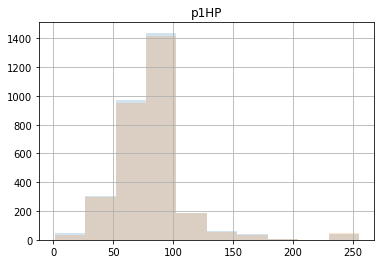

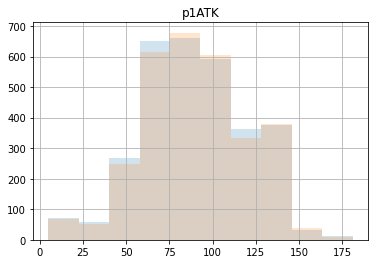

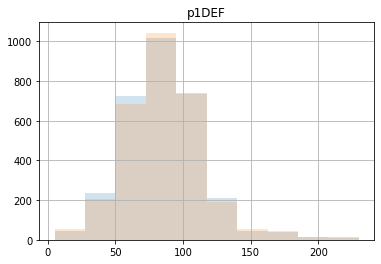

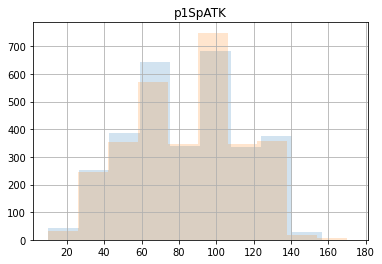

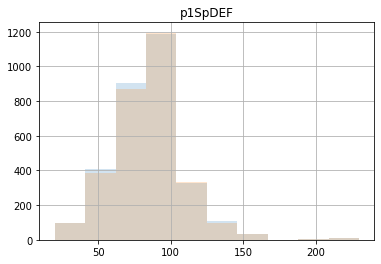

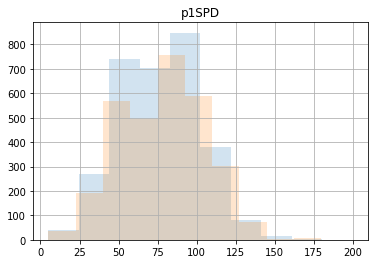

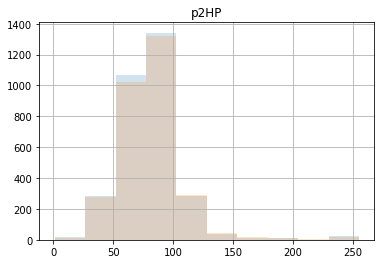

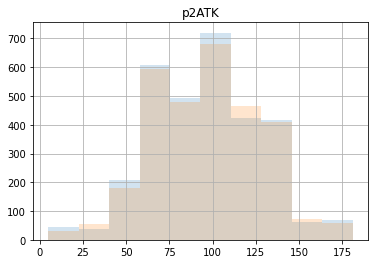

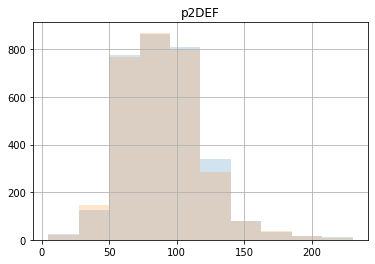

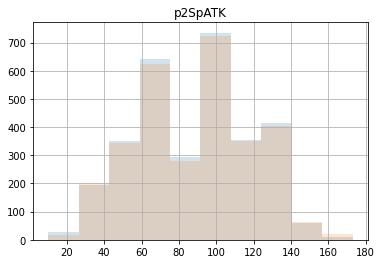

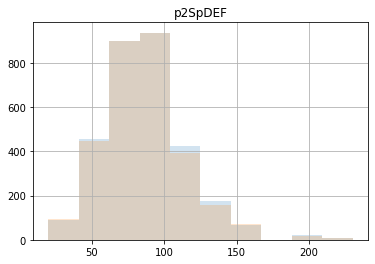

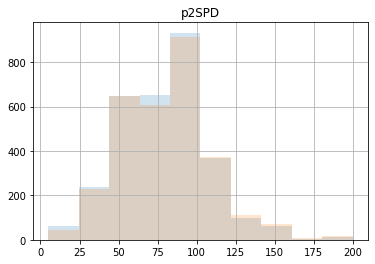

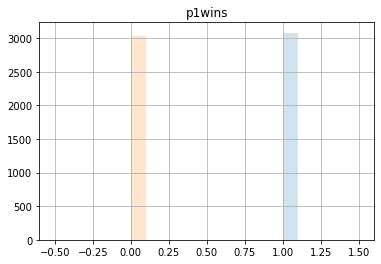

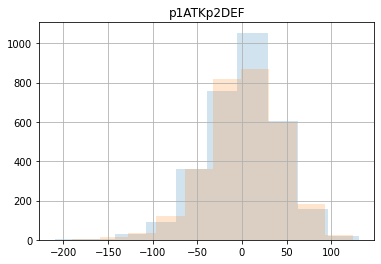

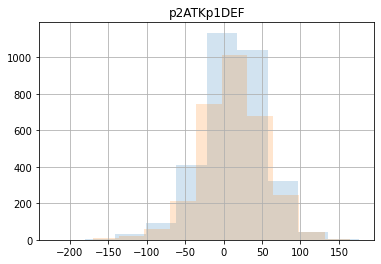

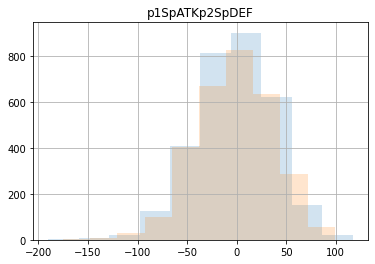

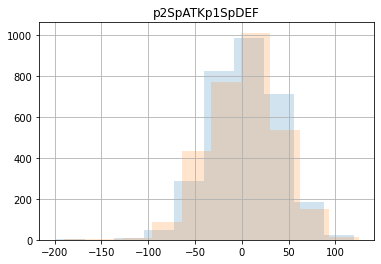

In [119]:
y = df['p1wins']
for col in df.columns: 
    df.loc[ df['p1wins'] == 1, col].hist(alpha=0.2)
    df.loc[ df['p1wins'] == 0, col].hist(alpha=0.2)
    plt.title(col)
    plt.show()

In [103]:
# normalise or stanasdfaksdf
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [106]:
from sklearn.linear_model import LogisticRegression

lr_hyperparameters = {
     'penalty': 'elasticnet', 
     'solver': 'saga', 
     'l1_ratio': 0.2
     }
lr = LogisticRegression(**lr_hyperparameters)
lr.fit(X_train_scaled, y_train.ravel())
y_score_lr = lr.predict_proba(X_train_scaled)
y_pred_score_lr = lr.predict_proba(scaler.transform(X_test))

train: 0.5342110574364969
test: 0.4980366272734892


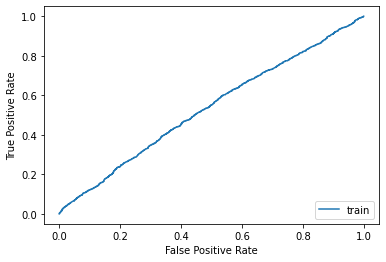

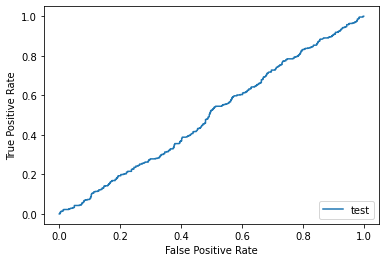

In [108]:
tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train.ravel(), y_score_lr[:, 1])

test_fpr, test_tpr, test_threshold = roc_curve(y_test.ravel(), y_pred_score_lr[:, 1])

print(f'train: {auc(tr_fpr, tr_tpr)}' )
print(f'test: {auc(test_fpr, test_tpr)}' )

RocCurveDisplay(fpr=tr_fpr, tpr=tr_tpr).plot(name='train')
RocCurveDisplay(fpr=test_fpr, tpr=test_tpr).plot(name='test')

## Modelling 
Trying:  
- kNN  
- logistic regression  
- decision tree

In [74]:
from sklearn.neighbors import KNeighborsClassifier

kNN_hyperparameters = {
     'n_neighbors': len(y_train), 
     'weights': 'distance',
     }
kNN = KNeighborsClassifier(**kNN_hyperparameters)
kNN.fit(X_train, y_train.ravel())  ## DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), using ravel()
y_pred_kNN = kNN.predict(X_test)
y_score_kNN = kNN.predict_proba(X_test)


In [75]:
from sklearn.linear_model import LogisticRegression

lr_hyperparameters = {
     'penalty': 'none', 
     }
lr = LogisticRegression(**lr_hyperparameters)
lr.fit(X_train, y_train.ravel())
y_pred_lr = lr.predict(X_test)
y_score_lr = lr.predict_proba(X_test)

In [76]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train.ravel())
y_score_tree = tree.predict_proba(X_train)
y_pred_score_tree = tree.predict_proba(X_test)


In [77]:
# random fit
y_pred_random = np.random.randint(1, len(y_test))

working
___

In [78]:
from sklearn.model_selection import GridSearchCV

grid = {
    'max_depth': [2, 5, 10, 20], 
    'min_samples_leaf': [5, 25, 50, 100, 1000]
    }

hypers = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid, return_train_score=True)

In [79]:
hypers.fit(X_train, y_train)


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'min_samples_leaf': [5, 25, 50, 100, 1000]},
             return_train_score=True)

In [80]:
pd.DataFrame( hypers.cv_results_ )[['params', 'mean_test_score', 'mean_train_score']]

,params,mean_test_score,mean_train_score
0,"{'max_depth': 2, 'min_samples_leaf': 5}",0.496798,0.522459
1,"{'max_depth': 2, 'min_samples_leaf': 25}",0.498334,0.522267
2,"{'max_depth': 2, 'min_samples_leaf': 50}",0.495521,0.529114
3,"{'max_depth': 2, 'min_samples_leaf': 100}",0.492704,0.528986
4,"{'max_depth': 2, 'min_samples_leaf': 1000}",0.485033,0.523995
5,"{'max_depth': 5, 'min_samples_leaf': 5}",0.494243,0.554326
6,"{'max_depth': 5, 'min_samples_leaf': 25}",0.492708,0.557590
7,"{'max_depth': 5, 'min_samples_leaf': 50}",0.495009,0.563668
8,"{'max_depth': 5, 'min_samples_leaf': 100}",0.488355,0.557845
9,"{'max_depth': 5, 'min_samples_leaf': 1000}",0.485033,0.523995


In [81]:
grid = {
    'max_depth': [20, 25, 30, 40], 
    'min_samples_leaf': [2, 4, 6, 8]
    }

hypers = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid, return_train_score=True)

hypers.fit(X_train, y_train)

pd.DataFrame( hypers.cv_results_ )[['params', 'mean_test_score', 'mean_train_score']]

,params,mean_test_score,mean_train_score
0,"{'max_depth': 20, 'min_samples_leaf': 2}",0.451500,0.846751
1,"{'max_depth': 20, 'min_samples_leaf': 4}",0.448943,0.806054
2,"{'max_depth': 20, 'min_samples_leaf': 6}",0.466597,0.773868
3,"{'max_depth': 20, 'min_samples_leaf': 8}",0.470441,0.751152
4,"{'max_depth': 25, 'min_samples_leaf': 2}",0.447918,0.877912
5,"{'max_depth': 25, 'min_samples_leaf': 4}",0.450988,0.824866
6,"{'max_depth': 25, 'min_samples_leaf': 6}",0.465830,0.783594
7,"{'max_depth': 25, 'min_samples_leaf': 8}",0.466602,0.756527
8,"{'max_depth': 30, 'min_samples_leaf': 2}",0.441003,0.886422
9,"{'max_depth': 30, 'min_samples_leaf': 4}",0.450217,0.829792


## Evaluation using ROC_curve and AUC


In [84]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay

0.9820584665951976


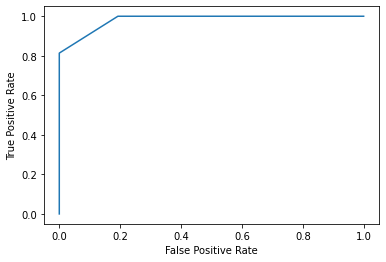

In [85]:
kNN.predict_proba(X_train)[:, 1]

tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train.ravel(), kNN.predict_proba(X_train)[:, 1])

print( auc(tr_fpr, tr_tpr) )

RocCurveDisplay(fpr=tr_fpr, tpr=tr_tpr).plot()

0.9820584665951976


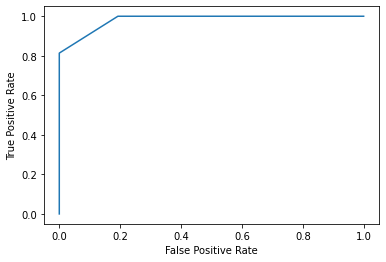

In [86]:
tr_fpr, tr_tpr, tr_threshold = roc_curve(y_train.ravel(), y_score_tree[:, 1])

print( auc(tr_fpr, tr_tpr) )

RocCurveDisplay(fpr=tr_fpr, tpr=tr_tpr).plot()

0.4064705389321934


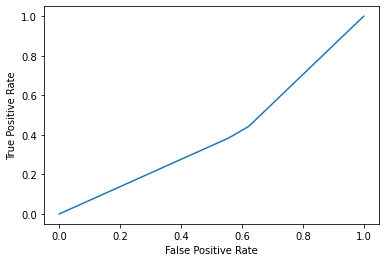

In [87]:
y_score_tree = tree.predict_proba(X_test)

tr_fpr, tr_tpr, tr_threshold = roc_curve(y_test.ravel(), y_pred_score_tree[:, 1])

print( auc(tr_fpr, tr_tpr) )

RocCurveDisplay(fpr=tr_fpr, tpr=tr_tpr).plot()


In [88]:

kNN_test_fpr, kNN_test_tpr, kNN_test_threshold = roc_curve(y_test.ravel(), y_score_kNN[:, 1])
print(f'kNN: {roc_auc_score(y_test.ravel(), y_score_kNN[:, 1])}')

lr_test_fpr, lr_test_tpr, lr_test_threshold = roc_curve(y_test.ravel(), y_score_lr[:, 1])
print(f'logistic regression: {roc_auc_score(y_test.ravel(), y_score_lr[:, 1])}')

kNN: 0.3509366356550163
logistic regression: 0.4978270890956332


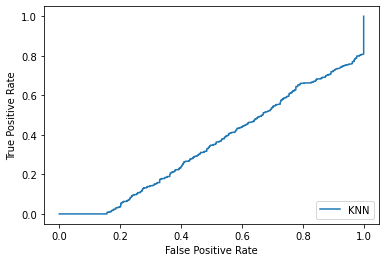

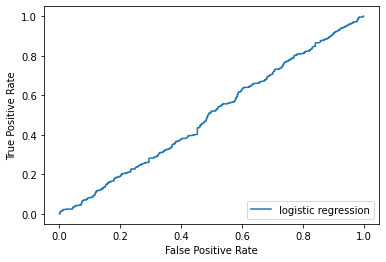

In [89]:
RocCurveDisplay(fpr=kNN_test_fpr, tpr=kNN_test_tpr).plot(name='KNN')
RocCurveDisplay(fpr=lr_test_fpr, tpr=lr_test_tpr).plot(name='logistic regression')

working on
___

## $f_m$ Optimisation
This is a measure of how good a particular threshold value is:   
$$ 
\begin{align}
    f_m &= \text{TPR} - m \times \text{FPR} \\
    m &= \frac{1 - \text{prevalence}}{\text{prevalence}} \times \frac{\text{cost of negative}}{\text{cost of positive}} \\
    \text{threshold}_{best} &= \mathrm{argmax}\ f_m
\end{align}
$$
Sometimes:  
$$
\begin{align}
    \text{cost of negative} &= \text{cost of False positive} - \text{cost of True negative} \\
    \text{cost of positive} &= \text{cost of False negative} - \text{cost of True positive} \\
    m &= \frac{1 - \text{prevalence}}{\text{prevalence}} \times \frac{C_{FP}-C_{TN}}{C_{FN}-C_{TP}}
\end{align}
$$
$\text{cost of negative}$ and $\text{cost of positive}$ are pre-determined values and usually we guess them based on the consequences for getting negative or positive results.  
So, within a set of values for threshold, the higher $f_m$ value, the better threshold. 

In [ ]:
class FmOptimisation()

    def __init__(self):
        pass
        
    
    